# Time-series inversion of sparsely connected and disconnected networks

In this notebook, we explore the effect of limited network connectivity and the inversion of disconnected networks. Such networks arrise if displacement measurements (links) between two acquisitions are missing. This can be the case if the correlator fails to find a reliable match, e.g. due to variable shadows or land-cover changes, or if specific pairing strategies reduce the number of image pairs. When a disconnected network is inverted, the inversion problem becomes ill-posed which makes it necessary to introduce a regularization term to the that helps to stabilize the solution. The Python code implementing the regularization was provided by Laurane Charrier and is based on previous work: [Charrier et al., 2022](https://isprs-annals.copernicus.org/articles/V-3-2022/311/2022/). 

In [1]:
# load neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from itertools import combinations
import random

#import functions for time-series inversion from relevant python script
import timeseries_inversion as inv

In [2]:
#create an artificial displacement signal (analog to previous notebook)
start_date = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_date = datetime.strptime('31/12/2023', '%d/%m/%Y')

dr = pd.date_range(start=start_date, end=end_date, freq='D')

#create synthetic cumulative displacement original_signal
#here: sigmoid + linear function
x = np.arange(0, len(dr), 1)
y = 0.01 * x + 20 / (1 + np.exp(-0.02 * (np.arange(len(dr)) - len(dr)/2)))
original_signal = pd.DataFrame({'date': dr, 'disp': y})

#create sample dates, here with a 3 month spacing
sample_dates = pd.date_range(start=start_date, end=end_date, freq='3MS')

#create image pairs from sample dates
date_combinations = list(combinations(sample_dates, 2))

network = pd.DataFrame(date_combinations, columns=['date0', 'date1'])

#find displacement for each datepair according to the synthetic signal
network['disp'] = network.apply(lambda row: inv.find_dsoll(row, original_signal), axis = 1)


## Sparsely connected networks

The more connections are missing in a network, the larger is the potential for bias introduced by erroneous measurements on the inverted time series. In the case of perfect pairwise measurements, the reconstruction accuracy is not affected by the number of connections, but noise-free conditions are rarely the case. In the following example, we restrict connections in the network to the next n neighbors (time steps) and showcase the effect of the same measurement errors on the resulting displacement signal. 

Number of image pairs: 190
Number of disconnected components in network: 0 
Number of image pairs: 19
Number of disconnected components in network: 0 
Number of image pairs: 54
Number of disconnected components in network: 0 


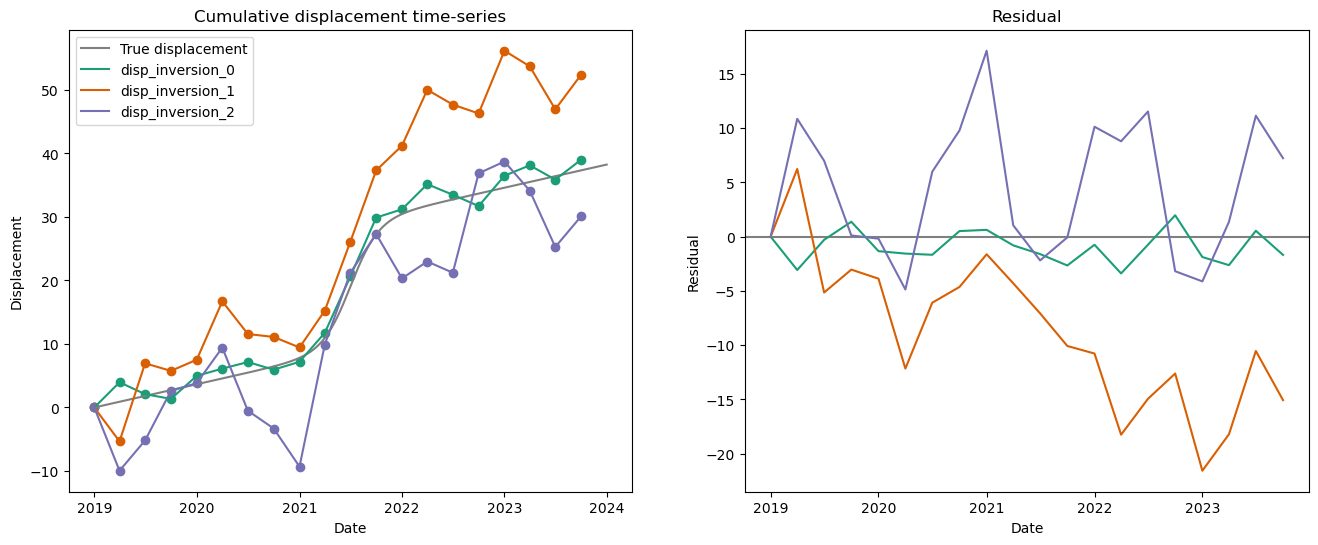

In [5]:
#simulate normally distributed measurement error
np.random.seed(123)
error = np.random.normal(0,5,len(network))

network["disp"] = network["disp"] + error

#now filter the network only choose the next neightbor (next aquisition date) to form image pairs
#
agg = network.groupby('date0')['date1'].agg(lambda x: x.nsmallest(1)).reset_index()
agg = agg.explode('date1')

network_nn1 = pd.merge(agg, network, on = ["date0", "date1"], how = "left")

#alternatively we could also allow for connections to the next 3 neighbors: 
agg = network.groupby('date0')['date1'].agg(lambda x: x.nsmallest(3)).reset_index()
agg = agg.explode('date1')

network_nn3 = pd.merge(agg, network, on = ["date0", "date1"], how = "left")

#now invert everthing and compare results
ts_nall = inv.run_inversion(network)
ts_nn1 = inv.run_inversion(network_nn1)
ts_nn3 = inv.run_inversion(network_nn3)
inv.plot_results([ts_nall, ts_nn3, ts_nn1], original_signal)

We can see that the network with connections only to the nearest neighbor generates the time series with the lowest reconstruction accuracy. 

## DI